# N Maximal Separation on a Grid
Let's lay out the problem, we have an 8x8 grid of cells. 

|   |   |   |   |   |   |   |   |
|---|---|---|---|---|---|---|---|
|   |   |   |   |   |   |   |   |
|   |   |   |   |   |   |   |   |
|   |   |   |   |   |   |   |   |
|   |   |   |   |   |   |   |   |
|   |   |   |   |   |   |   |   |
|   |   |   |   |   |   |   |   |
|   |   |   |   |   |   |   |   |  |

We want to select 8 of those cells such that

* No two cells lie on the same row or column
* The sum of the distances between every cell is maximized

For example, we could just put one along the diagonal

| x |   |   |   |   |   |   |   |
|:-:|:-:|:-:|:-:|:-:|:-:|:-:|:-:|
|   | x |   |   |   |   |   |   |
|   |   | x |   |   |   |   |   |
|   |   |   | x |   |   |   |   |
|   |   |   |   | x |   |   |   |
|   |   |   |   |   | x |   |   |
|   |   |   |   |   |   | x |   |
|   |   |   |   |   |   |   | x |

But it's pretty clear from inspection that the sum of distances is not maximized (the distance between each row for example is $\sqrt(2)$, let's write some helper functions and quickly calculate this example

In [1]:
# Helper functions
%pylab inline
import numpy as np
import itertools

def displayGrid(fill_cells,n=8):
    print("Displaying %dx%d using %d cells" % (n,n, fill_cells.shape[0]))
    row_labels = range(1,n+1)
    col_labels = range(1,n+1)
    grid = np.zeros([n,n])
    grid[fill_cells[:,0]-1, fill_cells[:,1]-1] = 1
    
    plt.matshow(grid)
    plt.xticks(range(n), col_labels)
    plt.yticks(range(n), row_labels)
    plt.show()

def sumDistances(pts):
    total_dist = 0
    k = pts.shape[0] # number of pts
    # Sum of all pairs of distances (skipping mirrored comparisons)
    for i in range(k):
        for j in range(i+1,k):
            total_dist += np.sqrt(np.sum(np.power( pts[j,:] - pts[i,:], 2)))
    return total_dist

Populating the interactive namespace from numpy and matplotlib


Alright, lets create a set of filled cells along the diagonal, display it and calculate the sum distances between them.

Displaying 8x8 using 8 cells


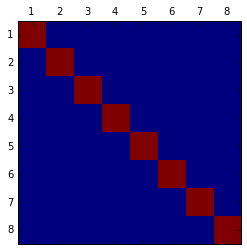

Cells:  [[1 1]
 [2 2]
 [3 3]
 [4 4]
 [5 5]
 [6 6]
 [7 7]
 [8 8]]
SumDist:  118.793939239


In [2]:
cells = np.array(list(enumerate(range(1,9),1)))
displayGrid(cells)
print("Cells: ", cells)
print("SumDist: ", sumDistances(cells))


The total sum for this arrangement is roughly 118.8 units, since there are $8*8 = 64$ pairs of distances, that's roughly 1.9 units distance on average, we should be able to do better than that.

# Finding maximal separation

For an 8x8 grid, the problem is probably small enough to brute force. At a first glance, we're choosing 8 cells from 64 cells.

$$
\binom{64}{8} = 4\,426\,165\,368
$$

So around 4 billion possible options. This might be doable, but it would take a while. 

We can reduce this greatly by noting one of the requirements (*no two cells may share a row or column*). Since we're placing 8 cells on an 8x8 grid, and none of them can share a row, then there has to be exactly 1 cell per row, and 1 cell per column, essentially the only option is which column. This reduces to $8! = 40\,320$ possible options, just 0.0009% of the previous set!

On top of that, since we're looking for maximal separation, we don't care about mirroring horizontally, bringing us down to $\frac{8!}{2} = 20\,160$ options to check.

In [3]:
def getAllOptions(n=8):
    """Return an n!/2 x n array of permuations"""
    num_options = int(np.math.factorial(n)/2)
    options = np.zeros([num_options, n], dtype=int)

    i = 0
    for option in itertools.permutations(range(n)):
        if option[0] < option[-1]:
            options[i,:] = option
            i += 1
    return options

def calculateAllSumDists(options, display_modulo=1000):
    n = options.shape[1]
    num_options = options.shape[0]
    
    # Calculate sum distances for every permutation
    all_sumdists = np.zeros(num_options)

    # Init fill cells, every row is in order, columns provided from options
    cells = np.zeros([n,2])
    cells[:,0] = np.arange(1,n+1)

    for i in range(num_options):
        if (i%display_modulo == 0):
            print("%5d/%5d..." % (i, num_options))
        cells[:,1] = options[i,:]

        all_sumdists[i] = sumDistances(cells)

    print("Done")
    return all_sumdists

In [7]:
# %%timeit -n1 -r1 # measure how long it takes to run this cell (breaks variables made here)
from time import sleep, perf_counter as pc
t0 = pc()
# Generate all 20,160 permutations
n = 8
options = getAllOptions(n)
all_sumdists = calculateAllSumDists(options)
print("Finished in %3.3f seconds" % (pc()-t0))

    0/20160...
 1000/20160...
 2000/20160...
 3000/20160...
 4000/20160...
 5000/20160...
 6000/20160...
 7000/20160...
 8000/20160...
 9000/20160...
10000/20160...
11000/20160...
12000/20160...
13000/20160...
14000/20160...
15000/20160...
16000/20160...
17000/20160...
18000/20160...
19000/20160...
20000/20160...
Done
Finished in 7.0354 seconds


Great, we've calculated the sum distances for all 20,160 options, let's have a look at the histogram before we select the best one.

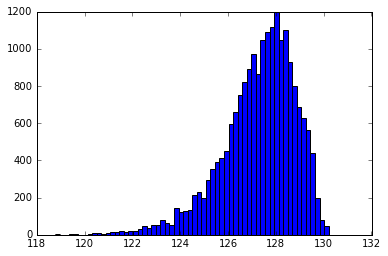

In [8]:
hist(all_sumdists, bins=60);

Well, looks like our initial diagonal array was special in that it was one of the worst possible orderings for maximal separation. If we were to take a random ordering in this space we'd probably fall somewhere in the bellcurve of around 128 units sum distance. Our best score is around 130 units, let's visualize this pairing.

In [9]:
def getAndDisplayBestOption(all_sumdists, options):
    best_idx = np.argmax(all_sumdists)
    best_cells = np.array(list(enumerate(options[best_idx,:],1)))
    print(best_cells)
    displayGrid(best_cells, options.shape[1])

[[1 3]
 [2 5]
 [3 1]
 [4 7]
 [5 0]
 [6 6]
 [7 2]
 [8 4]]
Displaying 8x8 using 8 cells


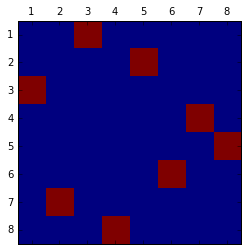

In [10]:
getAndDisplayBestOption(all_sumdists, options)

An interesting result, it looks almost like a diamond, or circle trying to maximally space all elements. Surprisingly there are two cells touching each other at (4,7) and (5,8). It'd be interesting to try this with a larger n.

In [12]:
t0 = pc()
n = 9
options = getAllOptions(n)
all_sumdists = calculateAllSumDists(options, display_modulo=10000)
print("Finished in %3.3f seconds" % (pc()-t0))

    0/181440...
10000/181440...
20000/181440...
30000/181440...
40000/181440...
50000/181440...
60000/181440...
70000/181440...
80000/181440...
90000/181440...
100000/181440...
110000/181440...
120000/181440...
130000/181440...
140000/181440...
150000/181440...
160000/181440...
170000/181440...
180000/181440...
Done
Finished in 80.937 seconds


[[1 3]
 [2 6]
 [3 1]
 [4 8]
 [5 4]
 [6 0]
 [7 7]
 [8 2]
 [9 5]]
Displaying 9x9 using 9 cells


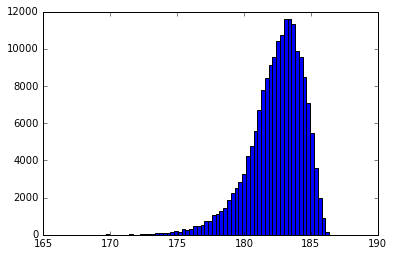

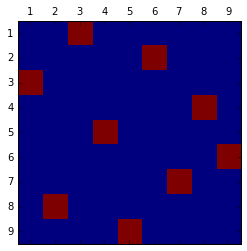

In [13]:
hist(all_sumdists, bins=60);
getAndDisplayBestOption(all_sumdists, options)

A circle with a cell in the middle, starting to look like a diagonal grid.